In [1]:
using PyPlot

In [2]:
#We need an object that has two methods: the parameters, which are its location in parameter space
#and chi2 of the model calculated from the walker's position compared to the data
type walker
    params::Array{Float64}
    chi2::Float64
end

In [3]:
#This is an object that records a given walker's position and chi2 across multiple steps 
type walker_record
    walkers::Array{walker}
    nsteps::Int64
end
walker_record(ws::Array{walker}) = walker_record(ws,length(ws))

walker_record

In [4]:
#enter each walker's record as an element of an array, one entry for each walker
type walker_array
    recs::Array{walker_record}
    nwalkers::Int8
end
walker_array(recs::Array{walker_record}) = walker_array(recs,length(recs))

walker_array

In [5]:
type model #contains a function, f(x,p), as well as nparams === length(p)
    f::Function
    nparams::Int8
end

In [6]:
#how to add a walker into a walker_record, and a walker_record into a walker_array,
#while keeping track of the number of steps taken/ the number of total walkers
import Base.push!
function push!(rec::walker_record,w::walker)
    push!(rec.walkers,w)
    rec.nsteps += 1
end
function push!(arr::walker_array,rec::walker_record)
    push!(arr.recs,rec)
    arr.nwalkers += 1
end

push! (generic function with 21 methods)

In [110]:
#returns chi2 at a position in parameter space
chi2(modl::model,params::Array{Float64},data::Array{Float64,2}) = sum(((modl.f(data[:,1],params).-data[:,2])./data[:,3]).^2)

chi2 (generic function with 1 method)

In [111]:
#Initialize a walker_array. nwalkers = nparams*3.0, nsteps=1, at the moment
function init_walkers(modl::model,p0::Array{Float64},p_err::Array{Float64},data::Array{Float64,2})
    nparam = modl.nparams
    nwalker = nparam*3.0
    chi_best = chi2(modl,p0,data)
    w_array = walker_array(walker_record[])
    for j=1:nwalker
        chi_trial = 1.0e100
        par_trial = p0
        while chi_trial > (chi_best + 1000)
            par_trial = p0 + p_err.*randn(nparam)
            chi_trial = chi2(modl,par_trial,data)
        end
        w = walker(par_trial,chi_trial)
        push!(w_array,walker_record([w]))
    end
    return w_array
end

init_walkers (generic function with 1 method)

In [112]:
function walk(w::walker,partner::walker,ascale::Float64,modl::model,data::Array{Float64,2})
    #Takes a walker and a partner, picks a new trial step based on parameters
    z=(rand()*(sqrt(ascale)-1.0/sqrt(ascale))+1.0/sqrt(ascale))^2
    par_trial = z.*w.params.+(1.0-z).*partner.params
    # Compute chi-square:    
    chi_trial=chi2(modl,par_trial,data)
    alp = z^(modl.nparams-1.0)*exp(-0.5*(chi_trial - w.chi2))
    return walker(par_trial,chi_trial),alp
end

walk (generic function with 1 method)

In [113]:
function mcmc(data::Array{Float64,2},modl::model,p0::Array{Float64},p_err::Array{Float64},nstep::Int64)
    w_array = init_walkers(modl,p0,p_err,data)
    nparam = modl.nparams
    nwalker = w_array.nwalkers
    ascale = 2.0
    accept = 0
    for i=2:nstep
        #Like j = nwalkers, but now we can access the walkers directly!
        for (j,rec) in enumerate(w_array.recs)
            current_w = rec.walkers[end]
            ipartner = j
            while ipartner == j
                ipartner = ceil(Int,rand()*nwalker)
            end
            partner_w = w_array.recs[ipartner].walkers[end]
            # Now, make a trial walker
            (trial_w,alp) = walk(current_w,partner_w,ascale,modl,data)
            if alp >= rand()
            # If step is accepted, add it to the chains!
                push!(rec,trial_w)
                accept = accept + 1
            else
            # Otherwise, copy the current walker
                push!(rec,current_w)
            end
        end
        if i%1000 == 0
            frac_acc = accept/(1000*nwalker)
            println("Number of steps: $i, acceptance rate: $frac_acc")
            ascale = 1.0 + (frac_acc/0.25)*(ascale-1.0)
            accept = 0
        end
    end
    return w_array
end

mcmc (generic function with 1 method)

In [114]:
get_history(w_array::walker_array,nwalk::Int64,p1::Int64,nstart::Int64) = [w.params[p1] for w in w_array.recs[nwalk].walkers[nstart:end]]

get_history (generic function with 1 method)

In [115]:
function get_median(w_array::walker_array,p1::Int64,nstart::Int64)
    plist = Float64[]
    for i=1:w_array.nwalkers
        append!(plist,get_history(w_array,i,p1,nstart))
    end
    return median(plist)
end

get_median (generic function with 1 method)

In [116]:
function get_mean(w_array::walker_array,p1::Int64,nstart::Int64)
    plist = Float64[]
    for i=1:w_array.nwalkers
        append!(plist,get_history(w_array,i,p1,nstart))
    end
    return mean(plist)
end

get_mean (generic function with 1 method)

In [117]:
function get_std(w_array::walker_array,p1::Int64,nstart::Int64)
    plist = Float64[]
    for i=1:w_array.nwalkers
        append!(plist,get_history(w_array,i,p1,nstart))
    end
    return std(plist)
end

get_std (generic function with 1 method)

In [132]:
function calc_iburn(w_array::walker_array)
    # Now, determine time of burn-in by calculating first time median is crossed:
    iburn = 0
    nparam = length(w_array.recs[1].walkers[1].params)
    nwalker = w_array.nwalkers
    nstep = w_array.recs[1].nsteps
    for i=1:nparam
        med_param=get_median(w_array,i,1)
        for rec in w_array.recs
            istep=2
            while (rec.walkers[istep].params[i] > med_param) == (rec.walkers[istep-1].params[i] > med_param) && (istep < nstep)
              istep=istep+1
            end
            if istep >= iburn
              iburn = istep
            end
        end
    end
    return iburn
end

calc_iburn (generic function with 1 method)

In [141]:
function get_params(w_array::walker_array,iburn::Int64)
    nparam = length(w_array.recs[1].walkers[1].params)
    params = Float64[get_mean(w_array,i,iburn) for i=1:nparam]
    stds = Float64[get_std(w_array,i,iburn) for i=1:nparam]
    return params,stds
end

get_params (generic function with 2 methods)

In [142]:
function plot_walkers(w_array::walker_array,p1::Int64,p2::Int64,nstart::Int64)
    pones = Float64[]
    ptwos = Float64[]
    for w=1:w_array.nwalkers
        append!(pones,get_history(w_array,w,p1,nstart))
        append!(ptwos,get_history(w_array,w,p2,nstart))
    end
    scatter(pones,ptwos)
end

plot_walkers (generic function with 2 methods)

In [143]:
function plot_histories(w_array::walker_array,p1::Int64,nstart::Int64)
    for w=1:w_array.nwalkers
        eyes = collect(1:w_array.recs[w].nsteps)
        vals = get_history(w_array,w,p1,nstart)
        plot(eyes,vals)
    end
    show()
end

plot_histories (generic function with 1 method)

In [144]:
function drop_the_mic(data::Array{Float64,2},modl::model,p0::Array{Float64},p_err::Array{Float64},nstep::Int64)
    final_walkers = mcmc(data,modl,p0,p_err,nstep)
    iburn = calc_iburn(final_walkers)
    for (par,std) in zip(get_params(final_walkers,iburn))
        println("$param +/- $std")
    end
    for i=2:modl.nparams
        for j=1:i-1
            plot_walkers(final_walkers,i,j,iburn)
            #show() #.jl file only
            clf()
        end
    end
    for i=1:modl.nparams
        plot_histories(final_walkers,i,1)
        #show() #.jl file only
        clf()
    end
end

drop_the_mic (generic function with 1 method)

In [145]:
drop_the_mic(data,modl,p0,perr,10000)

Number of steps: 1000, acceptance rate: 0.6756666666666666
Number of steps: 2000, acceptance rate: 0.5225
Number of steps: 3000, acceptance rate: 0.3715
Number of steps: 4000, acceptance rate: 0.3263333333333333
Number of steps: 5000, acceptance rate: 0.27466666666666667
Number of steps: 6000, acceptance rate: 0.2718333333333333
Number of steps: 7000, acceptance rate: 0.24116666666666667
Number of steps: 8000, acceptance rate: 0.25783333333333336
Number of steps: 9000, acceptance rate: 0.24433333333333335
Number of steps: 10000, acceptance rate: 0.25483333333333336


LoadError: LoadError: BoundsError: attempt to access ([0.9587817225090444,1.0965489193794284],)
  at index [2]
while loading In[145], in expression starting on line 1

In [126]:
mod_trial(x,p) = p[1].*x.+p[2]
modl = model(mod_trial,2)
xdata = collect(linspace(0,1,100))
ydata = mod_trial(xdata,[1.,1.])+rand(length(xdata))/10
yerr = rand(length(xdata))/10
data = hcat(xdata,ydata,yerr)
p0 = [0.9,1.1]
perr = [0.01,0.01]
foo = init_walkers(modl,p0,perr,data)
for rec in foo.recs
    push!(rec,walker([rand(),rand()],15.0))
end
results = mcmc(data,modl,p0,perr,10000) ;
println("done")
#errorbar(xdata,ydata,yerr=yerr,fmt="xb")
#This gives a walker_array object to test the following out on if you so choose

Number of steps: 1000, acceptance rate: 0.6953333333333334
Number of steps: 2000, acceptance rate: 0.5081666666666667
Number of steps: 3000, acceptance rate: 0.37766666666666665
Number of steps: 4000, acceptance rate: 0.31516666666666665
Number of steps: 5000, acceptance rate: 0.27416666666666667
Number of steps: 6000, acceptance rate: 0.2633333333333333
Number of steps: 7000, acceptance rate: 0.25366666666666665
Number of steps: 8000, acceptance rate: 0.242
Number of steps: 9000, acceptance rate: 0.24733333333333332
Number of steps: 10000, acceptance rate: 0.2585
done


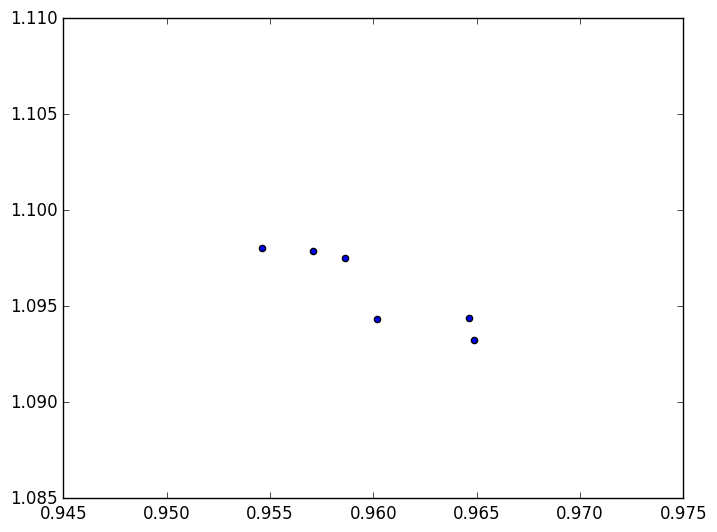

PyObject <matplotlib.collections.PathCollection object at 0x32282c890>

In [127]:
plot_walkers(results,1,2)

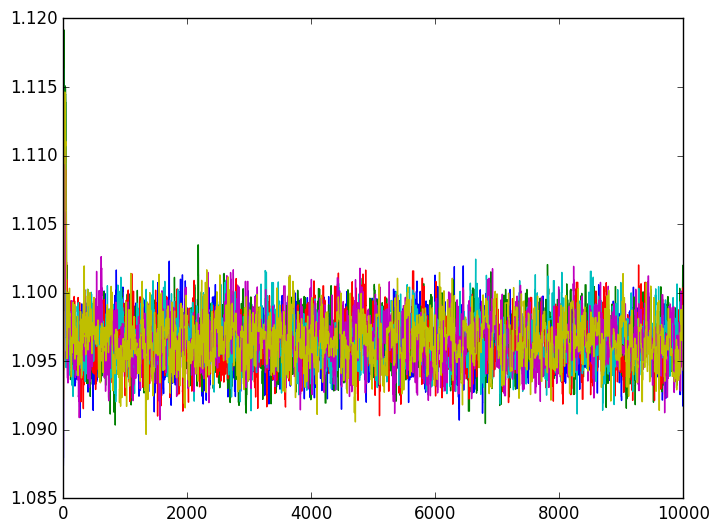

In [129]:
plot_histories(results,2,1)

In [102]:
data

100x3 Array{Float64,2}:
 0.0        1.02815  0.0810807 
 0.010101   1.03638  0.0114192 
 0.020202   1.10224  0.0343615 
 0.030303   1.06313  0.0652    
 0.040404   1.06397  0.0848287 
 0.0505051  1.05475  0.0302012 
 0.0606061  1.10938  0.0707363 
 0.0707071  1.1021   0.0898795 
 0.0808081  1.08375  0.00724207
 0.0909091  1.14181  0.0723807 
 0.10101    1.11224  0.0804241 
 0.111111   1.20045  0.0157322 
 0.121212   1.13463  0.0675996 
 ⋮                             
 0.888889   1.9853   0.048922  
 0.89899    1.93797  0.0529963 
 0.909091   1.99355  0.0707362 
 0.919192   1.95993  0.0955384 
 0.929293   2.01353  0.0418393 
 0.939394   1.97035  0.0240161 
 0.949495   1.96164  0.0415525 
 0.959596   2.02628  0.0251162 
 0.969697   2.06823  0.0619237 
 0.979798   2.00081  0.0197    
 0.989899   2.03026  0.0867496 
 1.0        2.06734  0.0112236 

In [109]:
data[:,3]

100-element Array{Float64,1}:
 0.0810807 
 0.0114192 
 0.0343615 
 0.0652    
 0.0848287 
 0.0302012 
 0.0707363 
 0.0898795 
 0.00724207
 0.0723807 
 0.0804241 
 0.0157322 
 0.0675996 
 ⋮         
 0.048922  
 0.0529963 
 0.0707362 
 0.0955384 
 0.0418393 
 0.0240161 
 0.0415525 
 0.0251162 
 0.0619237 
 0.0197    
 0.0867496 
 0.0112236 